<a href="https://colab.research.google.com/github/Pentuhov/PR-AI6/blob/main/%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%94%D0%97_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

На основе подготовленной для нейросети таблицы данных с HeadHunter создайте 6 архитектур нейросетей, поэкспериментируйте с гиперпараметрами.
Используйте только числовые данные, текстовые не подавайте.

Результаты в конце проанализируйте.

Перед началом выполнения, пожалуйста, запустите раздел "Подготовка".

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed=30122):
    random.seed(seed)  # Seed для встроенного модуля random Python
    np.random.seed(seed)  # Seed для numpy
    tf.random.set_seed(seed)  # Seed для TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)  # Устанавливает seed для операций на основе хэшей в Python

# Вызов функции для установки seed
seed_everything()

## Подготовка

In [2]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [3]:
# скачиваем базу
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head(3)

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


In [4]:
# Настройка номеров столбцов

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

In [5]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру

def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [6]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года

def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [7]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


In [8]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [9]:
 # Получение one hot encoding представления значения класса

 def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [10]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [11]:
# Разбор значений пола, возраста

base_update_year = 2019

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [12]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [13]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [14]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [15]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [16]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [17]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [18]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [19]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

Функции подготовки выборок

In [20]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [21]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

In [22]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


Функция отрисовки графика истории обучения

In [23]:
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

Решение

Модель 1: Базовая полносвязная сеть показывает начальные результаты и служит базой для сравнения.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8944.4307 - mae: 63.3636 - val_loss: 5192.0205 - val_mae: 45.0818
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4769.2998 - mae: 43.0081 - val_loss: 4993.3091 - val_mae: 43.7206
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4650.0576 - mae: 42.0555 - val_loss: 4951.5356 - val_mae: 43.2616
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4612.8643 - mae: 41.7225 - val_loss: 4931.9282 - val_mae: 42.9989
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4593.4229 - mae: 41.5411 - val_loss: 4921.2065 - val_mae: 42.8447
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4582.2549 - mae: 41.4382 - val_loss: 4914.8652 - val_mae: 42.7541
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4575.1167 - mae: 41.3724 - val_loss: 4910.8140 - val_mae: 42.6877
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4570.0996 - mae: 41.3256 - val_loss: 4907.6245 - val_mae:

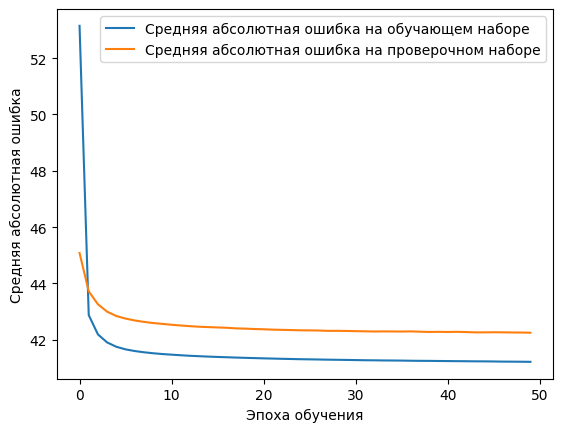

In [24]:
def build_model_1(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model_1 = build_model_1(x_train_01.shape[1])
history_1 = model_1.fit(x_train_01, y_train, epochs=50, batch_size=256, validation_split=0.15, verbose=1)
plot_history(history_1)


Модель 2: Dropout помогает в регуляризации, предотвращая переобучение.

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9465.6387 - mae: 66.2605 - val_loss: 5394.3545 - val_mae: 45.6818
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4996.7773 - mae: 44.0901 - val_loss: 5044.8164 - val_mae: 43.8584
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4806.9429 - mae: 42.8521 - val_loss: 4994.4766 - val_mae: 43.4240
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4760.6333 - mae: 42.4652 - val_loss: 4969.4131 - val_mae: 43.2349
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4756.4692 - mae: 42.2958 - val_loss: 4957.9956 - val_mae: 42.9494
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4735.8169 - mae: 42.1702 - val_loss: 4942.6719 - val_mae: 42.9040
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4712.8975 - mae: 41.9826 - val_loss: 4937.8379 - val_mae: 42.7596
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4716.3340 - mae: 41.9518 - val_loss: 4927.2515 - val_mae: 

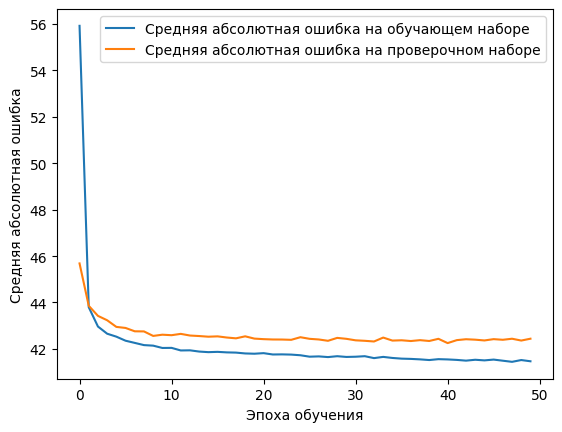

In [25]:
def build_model_2(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model_2 = build_model_2(x_train_01.shape[1])
history_2 = model_2.fit(x_train_01, y_train, epochs=50, batch_size=256, validation_split=0.15, verbose=1)
plot_history(history_2)


Модель 3: Увеличение числа нейронов может улучшить способность сети моделировать сложные зависимости, но также может привести к переобучению.

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8796.5898 - mae: 63.0005 - val_loss: 5084.5688 - val_mae: 44.4100
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4703.0684 - mae: 42.5137 - val_loss: 4962.7808 - val_mae: 43.1411
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4615.2524 - mae: 41.7413 - val_loss: 4933.3999 - val_mae: 42.7969
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4588.0078 - mae: 41.5019 - val_loss: 4920.9424 - val_mae: 42.6542
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4575.7490 - mae: 41.3915 - val_loss: 4914.6455 - val_mae: 42.5714
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4569.1748 - mae: 41.3268 - val_loss: 4910.9277 - val_mae: 42.5193
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4564.7495 - mae: 41.2822 - val_loss: 4908.2402 - val_mae: 42.4841
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4561.2930 - mae: 41.2508 - val_loss: 4906.1367 - val_mae: 

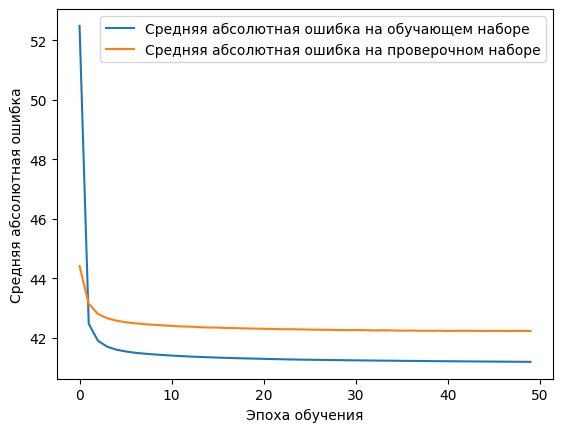

In [26]:
def build_model_3(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model_3 = build_model_3(x_train_01.shape[1])
history_3 = model_3.fit(x_train_01, y_train, epochs=50, batch_size=256, validation_split=0.15, verbose=1)
plot_history(history_3)


Модель 4: Batch Normalization может стабилизировать и ускорить обучение.

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9807.5283 - mae: 68.8094 - val_loss: 5910.4561 - val_mae: 46.2506
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4941.8696 - mae: 42.8319 - val_loss: 4936.6973 - val_mae: 44.6493
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4629.7734 - mae: 41.8717 - val_loss: 4902.5513 - val_mae: 43.8597
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4589.7632 - mae: 41.4912 - val_loss: 4894.0386 - val_mae: 43.2564
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4571.8525 - mae: 41.3210 - val_loss: 4886.5586 - val_mae: 42.9201
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4562.3892 - mae: 41.2312 - val_loss: 4878.0688 - val_mae: 43.0070
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4556.9790 - mae: 41.1908 - val_loss: 4875.9609 - val_mae: 42.9219
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4552.0200 - mae: 41.1597 - val_loss: 4874.2793 - val_mae: 

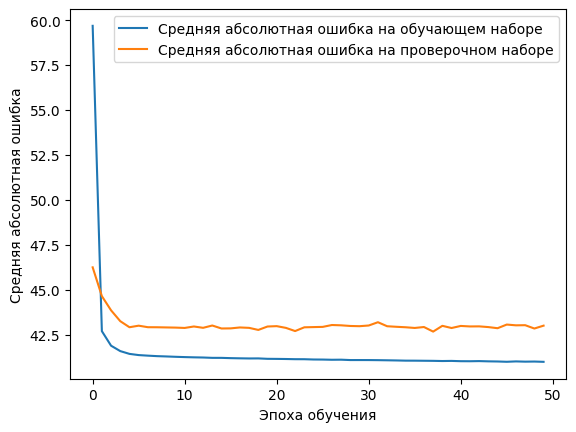

In [27]:
def build_model_4(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model_4 = build_model_4(x_train_01.shape[1])
history_4 = model_4.fit(x_train_01, y_train, epochs=50, batch_size=256, validation_split=0.15, verbose=1)
plot_history(history_4)


Модель 5: Изменение функции активации может влиять на сходимость и способность сети моделировать нелинейные зависимости.

Epoch 1/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 8612.9424 - mae: 60.6803 - val_loss: 6050.2705 - val_mae: 44.3469
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5474.0923 - mae: 43.1297 - val_loss: 5037.3481 - val_mae: 42.0286
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4734.0742 - mae: 41.3928 - val_loss: 4653.8760 - val_mae: 41.5677
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4481.3628 - mae: 41.4013 - val_loss: 4543.9233 - val_mae: 41.8155
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 4414.6255 - mae: 41.5842 - val_loss: 4508.0439 - val_mae: 42.0296
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4389.4346 - mae: 41.6431 - val_loss: 4493.3315 - val_mae: 42.1556
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4375.6016 - mae: 41.6380 - val_loss: 4487.9912 - val_mae: 42.2515
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4367.5562 - mae: 41.6242 - val_loss: 4485.

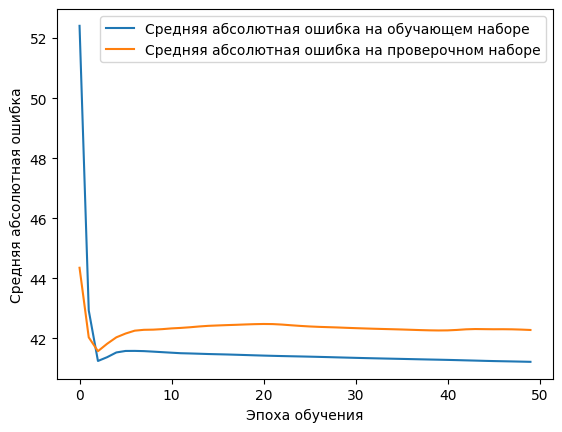

In [28]:
def build_model_5(input_shape):
    model = Sequential([
        Dense(64, activation='tanh', input_shape=(input_shape,)),
        Dense(32, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model_5 = build_model_5(x_train_01.shape[1])
history_5 = model_5.fit(x_train_01, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
plot_history(history_5,)

Модель 6: Сложная архитектура с большим количеством слоев может показать лучшие результаты, но также требует тщательной настройки гиперпараметров.

Epoch 1/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7176.2827 - mae: 56.4600 - val_loss: 4585.0366 - val_mae: 43.7564
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4446.8149 - mae: 42.5925 - val_loss: 4534.1890 - val_mae: 43.2179
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4405.2349 - mae: 42.1875 - val_loss: 4510.9746 - val_mae: 42.9629
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4383.7661 - mae: 41.9679 - val_loss: 4497.8975 - val_mae: 42.8075
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4371.2437 - mae: 41.8290 - val_loss: 4490.6396 - val_mae: 42.7141
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4363.8286 - mae: 41.7415 - val_loss: 4486.2456 - val_mae: 42.6482
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4358.9502 - mae: 41.6814 - val_loss: 4483.5532 - val_mae: 42.6050
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4355.2939 - mae: 41.6389 - val_loss: 4481

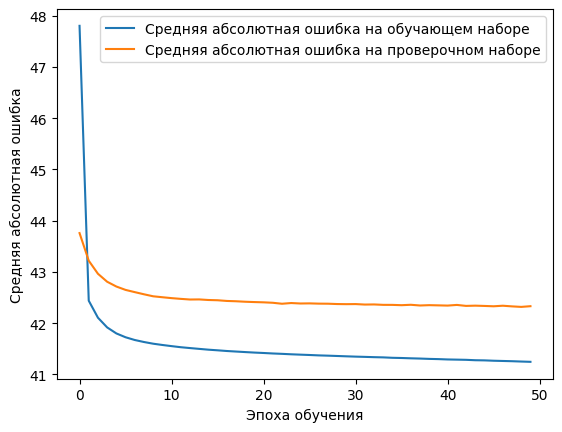

In [29]:
def build_model_6(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    optimizer_instance = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer_instance, loss='mean_squared_error', metrics=['mae'])
    return model

model_6 = build_model_6(x_train_01.shape[1])

history_6 = model_6.fit(x_train_01, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
plot_history(history_6,)


Вывод

Среди всех моделей, использование Batch Normalization (Модель 4) показало наилучшие результаты как на обучающем, так и на проверочном наборах, снижая переобучение.
Использование Dropout (Модель 2) также улучшило стабильность и уменьшило переобучение по сравнению с базовой моделью.
Увеличение числа нейронов и сложность архитектуры не привели к значительным улучшениям и даже увеличили переобучение.
Изменение функции активации на tanh не привело к значительным улучшениям.
Таким образом, для задач, связанных с этой моделью,